In [1]:
import math
import pandas as pd
import pandas_datareader as pdr
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import datetime as dt

In [2]:
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
df = pdr.DataReader('FB',data_source='yahoo',start='2016-01-01',end=dt.datetime.now())

In [3]:
df.tail()

High         Low        Open       Close    Volume  \
Date                                                                   
2021-06-16  337.549988  328.720001  336.700012  331.079987  17232200   
2021-06-17  337.980011  330.149994  330.489990  336.510010  17794100   
2021-06-18  336.149994  329.000000  334.529999  329.660004  23025100   
2021-06-21  332.920013  327.649994  331.089996  332.290009  11334600   
2021-06-22  339.920013  332.619995  332.684998  339.029999  15345299   

             Adj Close  
Date                    
2021-06-16  331.079987  
2021-06-17  336.510010  
2021-06-18  329.660004  
2021-06-21  332.290009  
2021-06-22  339.029999

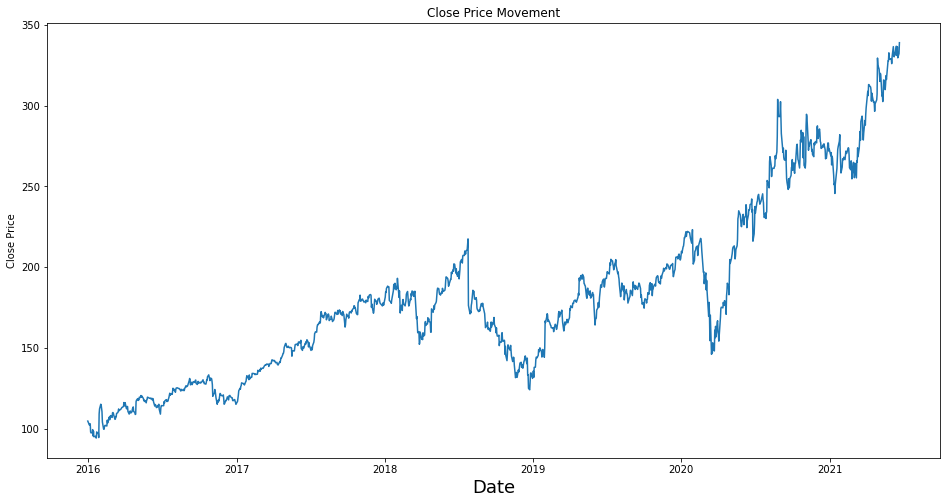

In [4]:
plt.figure(figsize=(16,8))
plt.title("Close Price Movement")
plt.plot(df['Close'])
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price")
plt.show()

In [5]:
sc = MinMaxScaler(feature_range = (0, 1))
scaled_data = sc.fit_transform(df['Close'].values.reshape(-1,1))
scaled_data

array([[0.0428799 ],
       [0.03291542],
       [0.03499816],
       ...,
       [0.96173482],
       [0.97247523],
       [1.        ]])

In [6]:
prediction_days = 60

In [7]:
x_train = []
y_train = []

for i in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[i-prediction_days:i,0])
    y_train.append(scaled_data[i,0])


In [8]:
x_train,Y_train = np.array(x_train),np.array(y_train)

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))



In [9]:
model = Sequential()
model.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train.shape[1], 1)))
#model.add(Dropout(0.2))
model.add(LSTM(units = 64, return_sequences = True))
#model.add(Dropout(0.2))
model.add(LSTM(units = 32))
model.add(Dropout(0.2))
model.add(Dense(units = 1))

In [10]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [11]:
model.fit(x_train, Y_train, epochs = 100, batch_size = 42)

Epoch 1/100
32/32 [==============================] - 21s 80ms/step - loss: 0.0397
Epoch 2/100
32/32 [==============================] - 3s 79ms/step - loss: 0.0044
Epoch 3/100
32/32 [==============================] - 3s 84ms/step - loss: 0.0036
Epoch 4/100
32/32 [==============================] - 3s 93ms/step - loss: 0.0033
Epoch 5/100
32/32 [==============================] - 2s 75ms/step - loss: 0.0036
Epoch 6/100
32/32 [==============================] - 3s 108ms/step - loss: 0.0033
Epoch 7/100
32/32 [==============================] - 4s 130ms/step - loss: 0.0034
Epoch 8/100
32/32 [==============================] - 4s 120ms/step - loss: 0.0032
Epoch 9/100
32/32 [==============================] - 4s 122ms/step - loss: 0.0026
Epoch 10/100
32/32 [==============================] - 3s 106ms/step - loss: 0.0032
Epoch 11/100
32/32 [==============================] - 3s 108ms/step - loss: 0.0029
Epoch 12/100
32/32 [==============================] - 4s 118ms/step - loss: 0.0026
Epoch 13/100
32/3

32/32 [==============================] - 3s 107ms/step - loss: 9.1784e-04
Epoch 100/100
32/32 [==============================] - 4s 123ms/step - loss: 7.7182e-04


In [12]:
test_df = pdr.DataReader('FB',data_source='yahoo',start='2020-01-01',end=dt.datetime.now())

In [13]:
actual_price = test_df['Close'].values

In [14]:
total_dataset = pd.concat((df['Close'],test_df['Close']),axis = 0)

In [15]:
model_inputs = total_dataset[len(total_dataset)-len(test_df)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = sc.fit_transform(model_inputs)

In [16]:
x_test = []

for i in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[i-prediction_days:i,0])

In [17]:
x_test = np.array(x_test)

x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))



In [18]:
prediction_Price = model.predict(x_test)
prediction_Price = sc.inverse_transform(prediction_Price)

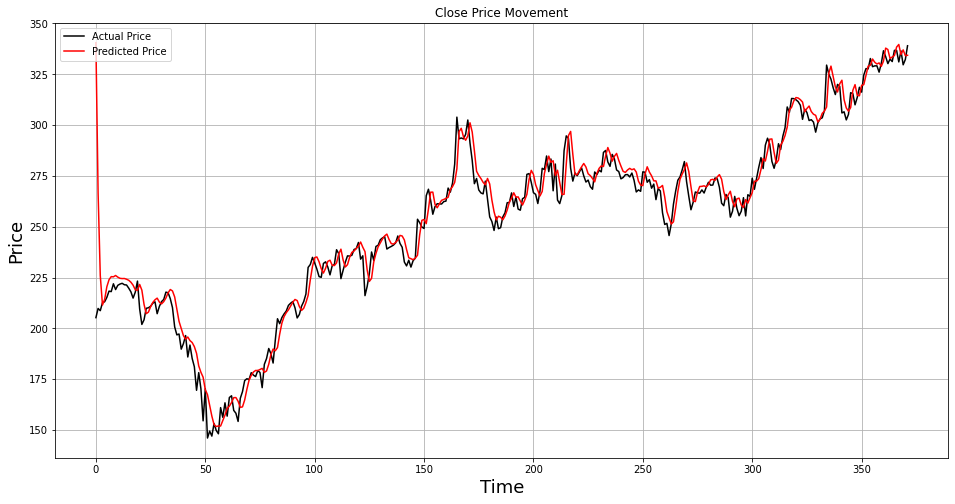

In [19]:
plt.figure(figsize=(16,8))
plt.title("Close Price Movement")
plt.plot(actual_price,color = 'black',label = 'Actual Price')
plt.plot(prediction_Price,color = 'red',label = 'Predicted Price')
plt.xlabel("Time",fontsize=18)
plt.ylabel("Price",fontsize=18)
plt.legend(loc = 'upper left')
plt.grid()
plt.show()

In [20]:
mse = np.mean(prediction_Price-actual_price)**2
mse#63.5440207342839#0.06031105639091126

5.41357252199585

In [21]:
rmse = np.sqrt(np.mean(prediction_Price-actual_price)**2)
rmse#7.971450353247136#0.24558309467654987

2.326708516766948

In [22]:
difference = prediction_Price-actual_price

In [23]:
difference = pd.DataFrame(difference)
difference.head()

0           1           2           3           4           5    \
0  135.290924  130.760925  131.870926  127.940918  127.480927  125.320923   
1   61.293640   56.763641   57.873642   53.943634   53.483643   51.323639   
2   20.678848   16.148849   17.258850   13.328842   12.868851   10.708847   
3    6.214111    1.684113    2.794113   -1.135895   -1.595886   -3.755890   
4    9.004883    4.474884    5.584885    1.654877    1.194885   -0.965118   

          6           7           8           9    ...         362  \
0  122.240921  122.480927  118.630920  121.480927  ...   10.290924   
1   48.243637   48.483643   44.633636   47.483643  ...  -63.706360   
2    7.628845    7.868851    4.018845    6.868851  ... -104.321152   
3   -6.835892   -6.595886  -10.445892   -7.595886  ... -118.785889   
4   -4.045120   -3.805115   -7.655121   -4.805115  ... -115.995117   

          363         364         365         366         367         368  \
0    8.080933    9.280914    3.770935    3.790924    9.460938    4.030914   
1  -65.916351  -64.716370  -70.226349  -70.206360  -64.536346  -69.966370   
2 -106.531143 -105.331161 -110.841141 -110.821152 -105.151138 -110.581161   
3 -120.995880 -119.795898 -125.305878 -125.285889 -119.615875 -125.045898   
4 -118.205109 -117.005127 -122.515106 -122.495117 -116.825104 -122.255127   

          369         370         371  
0   10.880920    8.250916    1.510925  
1  -63.116364  -65.746368  -72.486359  
2 -103.731155 -106.361160 -113.101151  
3 -118.195892 -120.825897 -127.565887  
4 -115.405121 -118.035126 -124.775116  

[5 rows x 372 columns]

In [24]:
real_data = [model_inputs[len(model_inputs)+1-prediction_days:len(model_inputs)+1,0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))


In [26]:
prediction = model.predict(real_data)
prediction = sc.inverse_transform(prediction)